In [2]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np

from sigvisa import Sigvisa
from sigvisa.graph.sigvisa_graph import SigvisaGraph
from sigvisa.signals.io import fetch_waveform
from sigvisa.source.event import Event

In [3]:
def setup_graph(sta="NV01"):
    stime = 1239041100 # should work for NV01 and TX01
    etime = 1239042100
    
    ev = Event(lon=-105.427, lat=43.731, depth=0.0, time=1239041017.07, mb=4.0)
    
    s = Sigvisa()
    cursor = s.dbconn.cursor()
    wave = fetch_waveform(sta, chan="auto", stime=stime, etime=etime, cursor=cursor)
    wave = wave.filter("freq_0.8_4.5;env;hz_2")
    
    sg = SigvisaGraph(template_model_type="param", template_shape="lin_polyexp",
                      wiggle_model_type="dummy", wiggle_family="iid", 
                      dummy_fallback=True, runids = (3,),
                      phases=["P", "S", "PcP", "ScP", "pP", "Pg", "Lg"], base_srate=2.0,
                      assume_envelopes=True, smoothing=None,
                      hack_param_constraint=True,
                      uatemplate_rate=1e-4)
    sg.add_wave(wave)
    evnodes = sg.add_event(ev, no_templates=True)
    return sg


In [4]:
sg = setup_graph()


n_uatemplate: -0.1
n_event: -8.0
ev priors: ev -5.7
ev observations: ev 0.0
tt_residual: ev 0.0
ev global cost (n + priors + tt): -13.7
coda_decay: ev 0.0 ua 0.0 total 0.0
peak_decay: ev 0.0 ua 0.0 total 0.0
peak_offset: ev 0.0 ua 0.0 total 0.0
coda_height: ev 0.0 ua 0.0 total 0.0
mult_std_wiggle: ev 0.0 ua 0.0 total 0.0
coef jointgp: 0.0
total param: ev 0.0 ua 0.0 total 0.0
priors+params: ev -13.7 ua -0.1 total -13.8
station noise (observed signals): -380.3
noise model prior lp: 7.4
overall: -386.7
official: -386.7
reading station detections... 


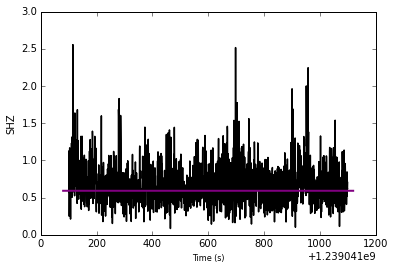

In [5]:
sg.current_log_p_breakdown()
wn = sg.station_waves.values()[0][0]
wn.plot(ax=plt.gca())

peak_lp -4.93599608286
param_lp [-3.81765295]
amp_lp 0.364780577281
{'coda_height': 0.3647805772805966, 'tt_residual': -4.9359960828620002, 'other': array([-3.81765295])}
[-389.94143231] -386.729607639 [-8.38886845]
[ 5.17704378]
reading station detections... 
n_uatemplate: -0.1
n_event: -8.0
ev priors: ev -5.7
ev observations: ev 0.0
tt_residual: ev -4.4
ev global cost (n + priors + tt): -18.2
coda_decay: ev -1.5 ua 0.0 total -1.5
peak_decay: ev -1.4 ua 0.0 total -1.4
peak_offset: ev -1.7 ua 0.0 total -1.7
coda_height: ev -2.1 ua 0.0 total -2.1
mult_std_wiggle: ev 0.8 ua 0.0 total 0.8
coef jointgp: 0.0
total param: ev -5.9 ua 0.0 total -5.9
priors+params: ev -24.1 ua -0.1 total -24.2
station noise (observed signals): -373.1
noise model prior lp: 7.4
overall: -389.9
official: -389.9


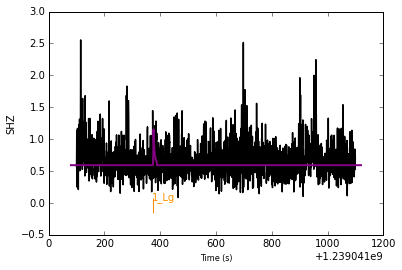

In [33]:
def current_template_proposal(sg, wn, eid, site="NVAR", phase="P"):
    from sigvisa.infer.event_birthdeath import propose_phase_template
    
    lp_old = sg.current_log_p()
    
    tg = sg.template_generator(phase)
    sg.add_event_site_phase(tg, site, phase, sg.evnodes[eid], sample_templates=True)
    sg._topo_sort()
    
    tmvals = sg.get_template_vals(eid, wn.sta, phase, wn.band, wn.chan)
    tmvals, tmpl_lp, debug_lps = propose_phase_template(sg, wn, eid, phase,
                                                        use_correlation=False,
                                                        prebirth_unexplained=None,
                                                        include_presampled = True,
                                                        tmvals = tmvals,
                                                        return_debug=True,
                                                        fix_result=False)
    
    print debug_lps
    
    sg.set_template(eid, wn.sta, phase, wn.band, wn.chan, tmvals)
    log_qforward = tmpl_lp
    lp_new = sg.current_log_p()
    print lp_new, lp_old, log_qforward
    return lp_new - (lp_old + log_qforward)

#np.random.seed(5)
a1 = current_template_proposal(sg, wn, eid=1, site="NVAR", phase="Lg")
print a1
wn.plot(ax=plt.gca())
sg.current_log_p_breakdown()
sg.delete_event_phase(eid=1, sta=wn.sta, phase="Lg")


reading station detections... 


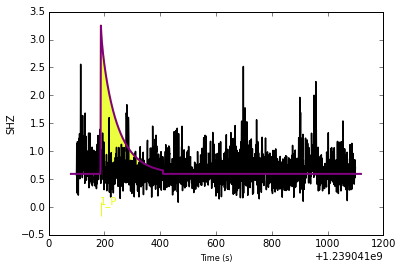